## Analyse IRM_Marche SMA
--
Parcellation en 444 regions (BASC Atlas) --> SEULEMENT SMA

Classification : SVM Linéaire

Sujets sains (66)

Classification Marche Confortable VS Rest
--
Cross validée par run (9)

In [75]:
import numpy as np
from scipy.stats import binom_test
from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from nilearn.datasets import load_mni152_brain_mask
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score
from sklearn.externals.joblib import Memory
%matplotlib inline
from nilearn.plotting import plot_stat_map
import sys
sys.path[0]='Z:/GitHub/gsp-learn/'
from gsplearn.GSPTransform import GraphTransformer
from gsplearn.GSPPlot import plot_selectedregions

In [8]:
motor_label=np.fromfile('F:/IRM_Marche/harv_sma_basc444asym.np','int')
#motor_label=np.arange(410,444)
fold='F:/IRM_marche/all_mni_imp_imag/'
smt='ss'       
names=('ap','as','bh','bi','boh','cmp','cas','cs','cb','gm','gn','gbn','mv',
       'ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs',
       'an','bm','cc','ci','cjf','dm','fb','fm','gem','gmc','hnc','lm','mac',
       'marc','marm','om','pic','pr','qs','ris','sn','tj','va',
       'af','ba','be','br','ds','ea','fj','gc','gv','hc','hn',
       'lbc','lc','lp','my','mc','pj','pf','rs','wl',#'dc',     
      )

scaler = preprocessing.StandardScaler()
svm= SVC(C=1., kernel="linear")  
pipeline = Pipeline([('scale', scaler),('svm', svm)])
k=50 #best 52
feature_selection = SelectKBest(f_classif, k=k)   
pipeline_anova = Pipeline([('anova', feature_selection), ('scale', scaler),('svm', svm)])

block=np.loadtxt(fold+'block.txt','int')
label=np.loadtxt(fold+'label.txt','S12')

mask_block=block==block
for x in range(label.shape[0]):
    if label[x]!=label[x-1]:
        mask_block[x]=False
    elif label[x]!=label[x-2]:
        mask_block[x]=False

condition_imp = np.logical_or(label == b'restimp', label == b'imp')
mask_imp= np.logical_and(condition_imp,mask_block)
condition_imag = np.logical_or(label == b'restimag', label == b'imag')
mask_imag= np.logical_and(condition_imag,mask_block)

y_imp = label[mask_imp]
y_imag = label[mask_imag]
block_cond = block[mask_imp]
cv = LeaveOneLabelOut(block_cond)
scores_imp=[]
scores_imag=[]
result_tr_imp=[]
result_tr_imag=[]
roi_imp_all=np.zeros([0,len(motor_label)])
roi_imag_all=np.zeros([0,len(motor_label)])
#roi_imp_all=np.zeros([0,444])
#roi_imag_all=np.zeros([0,444])
y_imp_all=np.zeros(0)
y_imag_all=np.zeros(0)

for i,n in enumerate(sorted(names)):
    roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi=roi[:,motor_label-1]
    roi_imp=roi[mask_imp]
    roi_imag=roi[mask_imag]
    roi_imp_all=np.vstack((roi_imp_all,roi_imp))
    roi_imag_all=np.vstack((roi_imag_all,roi_imag))
    y_imp_all=np.append(y_imp_all,y_imp)
    y_imag_all=np.append(y_imag_all,y_imag)
    scores_imp_cv = cross_val_score(
                                pipeline, roi_imp, y_imp,cv=cv)
    scores_imp.append(scores_imp_cv.mean())
    scores_imag_cv = cross_val_score(
                                pipeline, roi_imag, y_imag,cv=cv)
    scores_imag.append(scores_imag_cv.mean())
    pipeline.fit(roi_imp,y_imp)
    prediction = pipeline.predict(roi_imag)  
    result_tr_imp.append(accuracy_score(prediction,y_imp))
    pipeline.fit(roi_imag,y_imag)
    prediction = pipeline.predict(roi_imp)  
    result_tr_imag.append(accuracy_score(prediction,y_imag))

    print(n,scores_imp[i],scores_imag[i],result_tr_imp[i],result_tr_imag[i])
    ### Permutation (random par sujet)
    nb_p=1000
    null_result_tr_imag=np.zeros(nb_p)
    null_result_tr_imp=np.zeros(nb_p)
    for z in range(nb_p):
        suj_train_random=np.random.permutation(y_imp)
            
        pipeline.fit(roi_imp, suj_train_random)
        prediction = pipeline.predict(roi_imag) 
        null_result_tr_imp[z]=accuracy_score(prediction,y_imp)
    
        pipeline.fit(roi_imag, suj_train_random)
        prediction = pipeline.predict(roi_imp) 
        null_result_tr_imag[z]=accuracy_score(prediction,y_imp)

    sign_tr_imag=(null_result_tr_imag>=result_tr_imag[i]).sum()/nb_p
    sign_tr_imp=(null_result_tr_imp>=result_tr_imp[i]).sum()/nb_p
    print('tr_imp',sign_tr_imp,'tr_imag',sign_tr_imag)
print(np.array(scores_imp).mean(),np.array(scores_imag).mean(),np.array(result_tr_imp).mean(),np.array(result_tr_imag).mean())



af 0.482193732194 0.674501424501 0.535087719298 0.517543859649
tr_imag 0.39 tr_imp 0.41
an 0.586182336182 0.598290598291 0.587719298246 0.59649122807
tr_imag 0.097 tr_imp 0.067
ap 0.660256410256 0.719373219373 0.456140350877 0.535087719298
tr_imag 0.379 tr_imp 0.72
as 0.692307692308 0.466524216524 0.464912280702 0.456140350877
tr_imag 0.688 tr_imp 0.768
ba 0.591168091168 0.631054131054 0.5 0.456140350877
tr_imag 0.791 tr_imp 0.525
be 0.68660968661 0.589031339031 0.517543859649 0.543859649123
tr_imag 0.381 tr_imp 0.455
bh 0.527777777778 0.553418803419 0.456140350877 0.482456140351
tr_imag 0.682 tr_imp 0.774
bi 0.631054131054 0.788461538462 0.517543859649 0.491228070175
tr_imag 0.587 tr_imp 0.447
bm 0.72792022792 0.728632478632 0.666666666667 0.605263157895
tr_imag 0.158 tr_imp 0.067
boh 0.702991452991 0.534188034188 0.543859649123 0.587719298246
tr_imag 0.183 tr_imp 0.321
br 0.719373219373 0.816239316239 0.59649122807 0.5
tr_imag 0.532 tr_imp 0.274
cas 0.674501424501 0.834757834758 0.83

In [94]:
coef.shape

(1, 76)

In [73]:
coef_tr_imag=np.zeros([1,444])
coef_tr_imp=np.zeros([1,444])
#pipeline_anova.fit(roi_imag_all,y_imag_all)
pipeline.fit(roi_imag_all,y_imag_all)
#coef = pipeline_anova.named_steps['svm'].coef_
coef = pipeline.named_steps['svm'].coef_
#coef = pipeline_anova.named_steps['anova'].inverse_transform(coef)

for i,n in enumerate(motor_label):
    coef_tr_imag[0,n-1]=coef[0,i]
#coef_tr_imag=coef
#prediction = pipeline_anova.predict(roi_imp_all)  
prediction = pipeline.predict(roi_imp_all)  
print('p tr imag', binom_test((prediction==y_imag_all).sum(),n=len(y_imag_all),p=0.5))

result_tr_imag_all=accuracy_score(prediction,y_imag_all)

#pipeline_anova.fit(roi_imp_all,y_imp_all)
pipeline.fit(roi_imp_all,y_imp_all)
#coef = pipeline_anova.named_steps['svm'].coef_
coef = pipeline.named_steps['svm'].coef_
#coef = pipeline_anova.named_steps['anova'].inverse_transform(coef)
for i,n in enumerate(motor_label):
    coef_tr_imp[0,n-1]=coef[0,i]
#coef_tr_imp=coef
#prediction = pipeline_anova.predict(roi_imag_all)  
prediction = pipeline.predict(roi_imag_all)  
result_tr_imp_all=accuracy_score(prediction,y_imp_all)
print('p tr imp', binom_test((prediction==y_imp_all).sum(),n=len(y_imp_all),p=0.5))

print('All','train imag',result_tr_imag_all,'train imp',result_tr_imp_all)


p tr imag 3.39575857219e-70
p tr imp 8.14210600937e-91
All train imag 0.601807549176 train imp 0.616028708134


Visualisation des poids du SVM (regions qui permettent la classification): sur classif globale

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


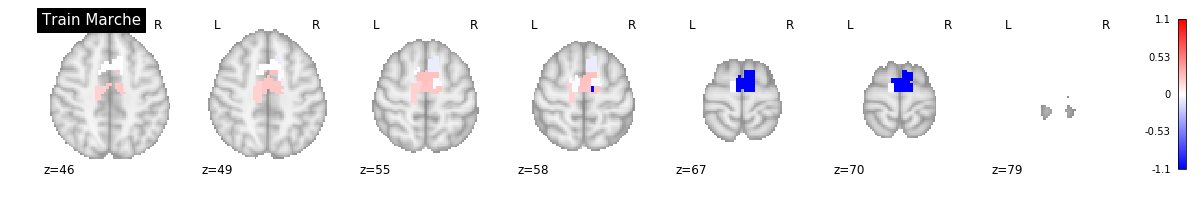

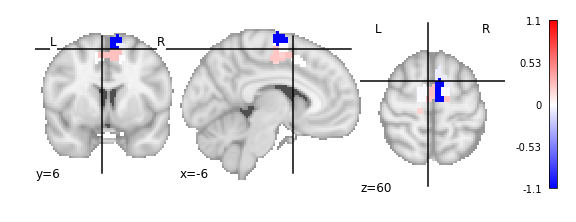

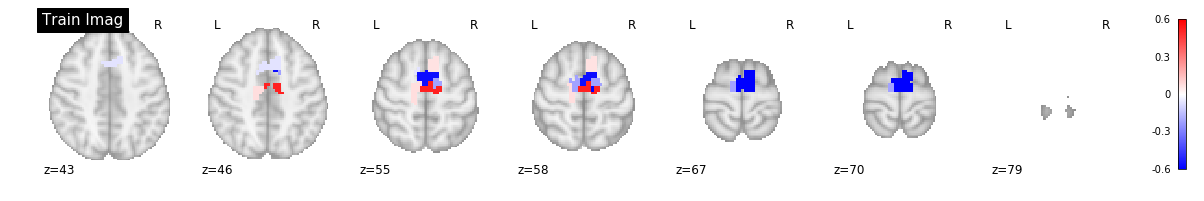

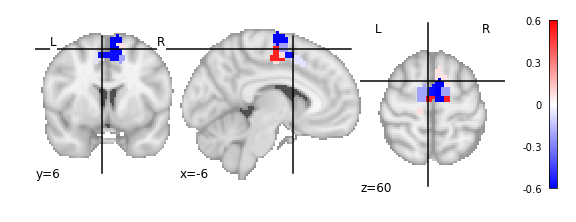

In [4]:

mem = Memory('nilearn_cache')
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')['scale444']

brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory=mem, memory_level=1, verbose=0,
                           detrend=False, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels')
masker.fit()

weight_img_trimp = masker.inverse_transform(coef_tr_imp)
plot_stat_map(weight_img_trimp, title='Train Marche',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trimp,cmap='bwr', cut_coords=[-6, 6, 60])
weight_img_trimag = masker.inverse_transform(coef_tr_imag)
plot_stat_map(weight_img_trimag, title='Train Imag',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trimag,cmap='bwr', cut_coords=[-6, 6, 60])

In [5]:
### Permutation (random par sujet)
nb_p=1000
null_result_tr_imag=np.zeros(nb_p)
null_result_tr_imp=np.zeros(nb_p)
nb_s=len(names)
for i in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    for suj in range(nb_s):
        suj_train_random=np.random.permutation(y_imp)
        y_train_random=np.append(y_train_random,suj_train_random)

        
    pipeline.fit(roi_imp_all, y_train_random)
    prediction = pipeline.predict(roi_imag_all) 
    null_result_tr_imp[i]=accuracy_score(prediction,y_imp_all)
    
    pipeline.fit(roi_imag_all, y_train_random)
    prediction = pipeline.predict(roi_imp_all) 
    null_result_tr_imag[i]=accuracy_score(prediction,y_imp_all)

sign_tr_imag=(null_result_tr_imag>=result_tr_imag_all).sum()/nb_p
sign_tr_imp=(null_result_tr_imp>=result_tr_imp_all).sum()/nb_p
print('tr_imag',sign_tr_imag,'tr_imp',sign_tr_imp)

tr_imag 0.019 tr_imp 0.031


# Apprentissage sur tous - test indiv

In [71]:
result_tr_imp=[]
result_tr_imag=[]
nb_s=len(names)
nb_p=1000
null_result_tr_imag=np.zeros((nb_s,nb_p))
null_result_tr_imp=np.zeros((nb_s,nb_p))
for i,n in enumerate(sorted(names)):
    roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi=roi[:,motor_label-1]
    roi_imp=roi[mask_imp]
    roi_imag=roi[mask_imag]
    pipeline.fit(roi_imp_all,y_imp_all)    
    prediction = pipeline.predict(roi_imag)  
    result_tr_imp.append(accuracy_score(prediction,y_imp))
    pipeline.fit(roi_imag_all,y_imag_all)
    prediction = pipeline.predict(roi_imp)  
    result_tr_imag.append(accuracy_score(prediction,y_imag))
    
for z in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    for suj in range(nb_s):
        suj_train_random=np.random.permutation(y_imp)
        y_train_random=np.append(y_train_random,suj_train_random) 
    pipeline.fit(roi_imp_all, y_train_random)        
    for i,n in enumerate(sorted(names)):
        roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
        roi=np.load(roi_name)['roi']
        roi=roi[:,motor_label-1]
        roi_imp=roi[mask_imp]
        roi_imag=roi[mask_imag]        
        prediction = pipeline.predict(roi_imag) 
        null_result_tr_imp[i,z]=accuracy_score(prediction,y_imp)
        
    pipeline.fit(roi_imag_all, y_train_random)    
    for i,n in enumerate(sorted(names)):
        roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
        roi=np.load(roi_name)['roi']
        roi=roi[:,motor_label-1]
        roi_imp=roi[mask_imp]
        roi_imag=roi[mask_imag]   
        prediction = pipeline.predict(roi_imp) 
        null_result_tr_imag[i,z]=accuracy_score(prediction,y_imp)

for i,n in enumerate(sorted(names)):        
    sign_tr_imag=(null_result_tr_imag[i,:]>=result_tr_imag[i]).sum()/nb_p
    sign_tr_imp=(null_result_tr_imp[i,:]>=result_tr_imp[i]).sum()/nb_p
    print(n,'tr_imp',result_tr_imp[i],'tr_imp',sign_tr_imp,'tr_imag',result_tr_imag[i],'tr_imag',sign_tr_imag)






af tr_imp 0.631578947368 tr_imp 0.171 tr_imag 0.508771929825 tr_imag 0.455
an tr_imp 0.614035087719 tr_imp 0.042 tr_imag 0.561403508772 tr_imag 0.187
ap tr_imp 0.719298245614 tr_imp 0.002 tr_imag 0.622807017544 tr_imag 0.07
as tr_imp 0.5 tr_imp 0.539 tr_imag 0.622807017544 tr_imag 0.082
ba tr_imp 0.561403508772 tr_imp 0.254 tr_imag 0.447368421053 tr_imag 0.822
be tr_imp 0.587719298246 tr_imp 0.209 tr_imag 0.614035087719 tr_imag 0.127
bh tr_imp 0.526315789474 tr_imp 0.357 tr_imag 0.412280701754 tr_imag 0.938
bi tr_imp 0.684210526316 tr_imp 0.109 tr_imag 0.508771929825 tr_imag 0.486
bm tr_imp 0.701754385965 tr_imp 0.032 tr_imag 0.59649122807 tr_imag 0.187
boh tr_imp 0.517543859649 tr_imp 0.418 tr_imag 0.631578947368 tr_imag 0.071
br tr_imp 0.631578947368 tr_imp 0.214 tr_imag 0.69298245614 tr_imag 0.053
cas tr_imp 0.80701754386 tr_imp 0.003 tr_imag 0.771929824561 tr_imag 0.0
cb tr_imp 0.631578947368 tr_imp 0.112 tr_imag 0.587719298246 tr_imag 0.126
cc tr_imp 0.578947368421 tr_imp 0.079 tr

In [74]:

from sklearn.dummy import DummyClassifier
nb_p=1000
dumsco=np.zeros(nb_p)
dummy=DummyClassifier()
dummy.fit(roi_imp_all,y_imp_all) 
for n in range(nb_p):
    dumsco[n]=dummy.score(roi_imag_all,y_imp_all)

print(dumsco.mean(),dumsco.max(),dumsco.min())

0.500301568315 0.519404572036 0.482456140351


In [70]:
from scipy.stats import binom_test
result_tr_imp=[]
result_tr_imag=[]
stat_trimp=[]
stat_trimag=[]
for i,n in enumerate(sorted(names)):
    roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi=roi[:,motor_label-1]
    roi_imp=roi[mask_imp]
    roi_imag=roi[mask_imag]
    pipeline.fit(roi_imp_all,y_imp_all)    
    prediction = pipeline.predict(roi_imag) 
    stat_trimp.append(binom_test((prediction==y_imp).sum(),n=len(y_imp),p=0.5))
    result_tr_imp.append(accuracy_score(prediction,y_imp))
    pipeline.fit(roi_imag_all,y_imag_all)
    prediction = pipeline.predict(roi_imp)  
    result_tr_imag.append(accuracy_score(prediction,y_imag))
    stat_trimag.append(binom_test((prediction==y_imag).sum(),n=len(y_imag),p=0.5))
    print(n,'tr_imp',result_tr_imp[i],stat_trimp[i],'tr_imag',result_tr_imag[i],stat_trimag[i])
       
    

af tr_imp 0.631578947368 0.0063516239199 tr_imag 0.508771929825 0.925434961257
an tr_imp 0.614035087719 0.0188107488249 tr_imag 0.561403508772 0.223230362456
ap tr_imp 0.719298245614 3.13852461616e-06 tr_imag 0.622807017544 0.0111185934488
as tr_imp 0.5 1.0 tr_imag 0.622807017544 0.0111185934488
ba tr_imp 0.561403508772 0.223230362456 tr_imag 0.447368421053 0.30287755263
be tr_imp 0.587719298246 0.0746925300798 tr_imag 0.614035087719 0.0188107488249
bh tr_imp 0.526315789474 0.639769368643 tr_imag 0.412280701754 0.0746925300798
bi tr_imp 0.684210526316 0.000104236705616 tr_imag 0.508771929825 0.925434961257
bm tr_imp 0.701754385965 1.95963680348e-05 tr_imag 0.59649122807 0.0487246863987
boh tr_imp 0.517543859649 0.778876092003 tr_imag 0.631578947368 0.0063516239199
br tr_imp 0.631578947368 0.0063516239199 tr_imag 0.69298245614 4.60924737125e-05
cas tr_imp 0.80701754386 2.28318634994e-11 tr_imag 0.771929824561 4.5895722935e-09
cb tr_imp 0.631578947368 0.0063516239199 tr_imag 0.5877192982

In [68]:
len(prediction==y_imp)


114